## Big Data Management Lab 3

## Dashboarding

In this notebook we load the data from the exploitation zone, and create the graphs for our final dashboard.

In [10]:
# Install and setup PySpark
!pip install pyspark

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os

In [12]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Lab3-Exploitation-Zone") \
    .master("local[*]") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

print("Spark Session Created Successfully!")
print(f"Spark Version: {spark.version}")
spark.sparkContext.setLogLevel("ERROR")

Spark Session Created Successfully!
Spark Version: 3.5.1


In [13]:
#Display all the configurations
print(f"Python version = {spark.sparkContext.pythonVer}")
print(f"Spark version = {spark.sparkContext.version}")
print(spark.sparkContext.getConf().getAll())

Python version = 3.11
Spark version = 3.5.1
[('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.sql.adaptive.enabled', 'true'), ('spark.executor.id',

In [14]:
# Retrieve the level of parallelism configured (equal to the number of cores is obtained with "*")
print("Master: ",spark.conf.get("spark.master"))
print("Parallelism: ",spark.sparkContext.defaultParallelism)
print("Minimum number of partitions: ",spark.sparkContext.defaultMinPartitions)

Master:  local[*]
Parallelism:  2
Minimum number of partitions:  2


In [15]:
from google.colab import drive
import os
from datetime import datetime

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Auto-generate project name or let user customize
def setup_project():
    """Interactive setup for the data pipeline project"""
    print("\n" + "="*60)
    print("DATA PIPELINE PROJECT SETUP")
    print("="*60)

    # Option 1: Use default name with timestamp
    default_name = f"data-pipeline-{datetime.now().strftime('%Y%m%d')}"

    print(f"\nDefault project name: {default_name}")
    user_input = input("Press Enter to use default, or type a custom project name: ").strip()

    project_name = user_input if user_input else default_name

    return project_name

# Get project name
PROJECT_NAME = setup_project()

# Set up all paths
BASE_DRIVE_PATH = "/content/drive/MyDrive"
DRIVE_PATH = f"{BASE_DRIVE_PATH}/{PROJECT_NAME}"
LANDING_ZONE = f"{DRIVE_PATH}/landing_zone"
FORMATTED_ZONE = f"{DRIVE_PATH}/formatted_zone"
EXPLOITATION_ZONE = f"{DRIVE_PATH}/exploitation_zone"

# Create directories
def create_project_structure():
    """Create the complete project folder structure"""
    directories = {
        "Project Root": DRIVE_PATH,
        "Landing Zone": LANDING_ZONE,
        "Formatted Zone": FORMATTED_ZONE,
        "Exploitation Zone": EXPLOITATION_ZONE
    }

    print(f"\nCreating project structure in: {DRIVE_PATH}")
    print("-" * 40)

    for name, path in directories.items():
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"✓ Created {name}: {path}")
        else:
            print(f"✓ {name} exists: {path}")

# Run the setup
create_project_structure()

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

DATA PIPELINE PROJECT SETUP

Default project name: data-pipeline-20250623
Press Enter to use default, or type a custom project name: dbm-lab3

Creating project structure in: /content/drive/MyDrive/dbm-lab3
----------------------------------------
✓ Project Root exists: /content/drive/MyDrive/dbm-lab3
✓ Landing Zone exists: /content/drive/MyDrive/dbm-lab3/landing_zone
✓ Formatted Zone exists: /content/drive/MyDrive/dbm-lab3/formatted_zone
✓ Exploitation Zone exists: /content/drive/MyDrive/dbm-lab3/exploitation_zone


## Loading the data from the exploitation zone

We stored the data in two tables:
- One on a district-year granularity
- One on a city-year granularity

This was because our inequality KPI did not make sense to store on a district level, since this is a city-wide KPI we wanted to track.

In [16]:
district_kpis = spark.read.parquet('/content/drive/MyDrive/dbm-lab3/exploitation_zone/barcelona_district_year_kpis')
city_kpis = spark.read.parquet('/content/drive/MyDrive/dbm-lab3/exploitation_zone/barcelona_city_year_kpis')

In [17]:
district_kpis.show()

+--------------+----+--------------------------+----------------------+--------------------------+-------------------+---------------------------+-----------------+----------------+-------------------------------+
| district_name|year|kpi_1_cultural_sites_count|kpi_2_avg_price_per_m2|kpi_2_price_growth_percent|kpi_3_avg_rfd_index|kpi_3_income_growth_percent|kpi_5_price_index|total_population|kpi_6_population_growth_percent|
+--------------+----+--------------------------+----------------------+--------------------------+-------------------+---------------------------+-----------------+----------------+-------------------------------+
|  Ciutat Vella|2013|                       124|                2624.0|                      NULL|               84.3|                       NULL|             96.0|          103944|                           NULL|
|  Ciutat Vella|2014|                       124|                2821.0|                       7.5|               85.4|                        1.

In [18]:
city_kpis.show()

+----+--------------------+-----------------------+------------+---------------------+--------------+
|year|kpi_4_inequality_gap|kpi_4_inequality_change|city_avg_rfd|city_total_population|city_avg_price|
+----+--------------------+-----------------------+------------+---------------------+--------------+
|2013|               205.4|                   NULL|        91.5|              1613885|        2436.0|
|2014|               217.0|                   11.6|        91.3|              1613392|        2465.0|
|2015|               216.0|                   -1.0|        92.3|              1609549|        2667.0|
|2016|               208.1|                   -7.9|        93.0|              1610427|        2757.0|
|2017|               210.2|                    2.1|        93.7|              1625137|        3330.0|
+----+--------------------+-----------------------+------------+---------------------+--------------+



## Dashboard Creation

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [20]:
# Set clean style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [21]:
# Convert to pandas
district_df = district_kpis.toPandas()
city_df = city_kpis.toPandas()

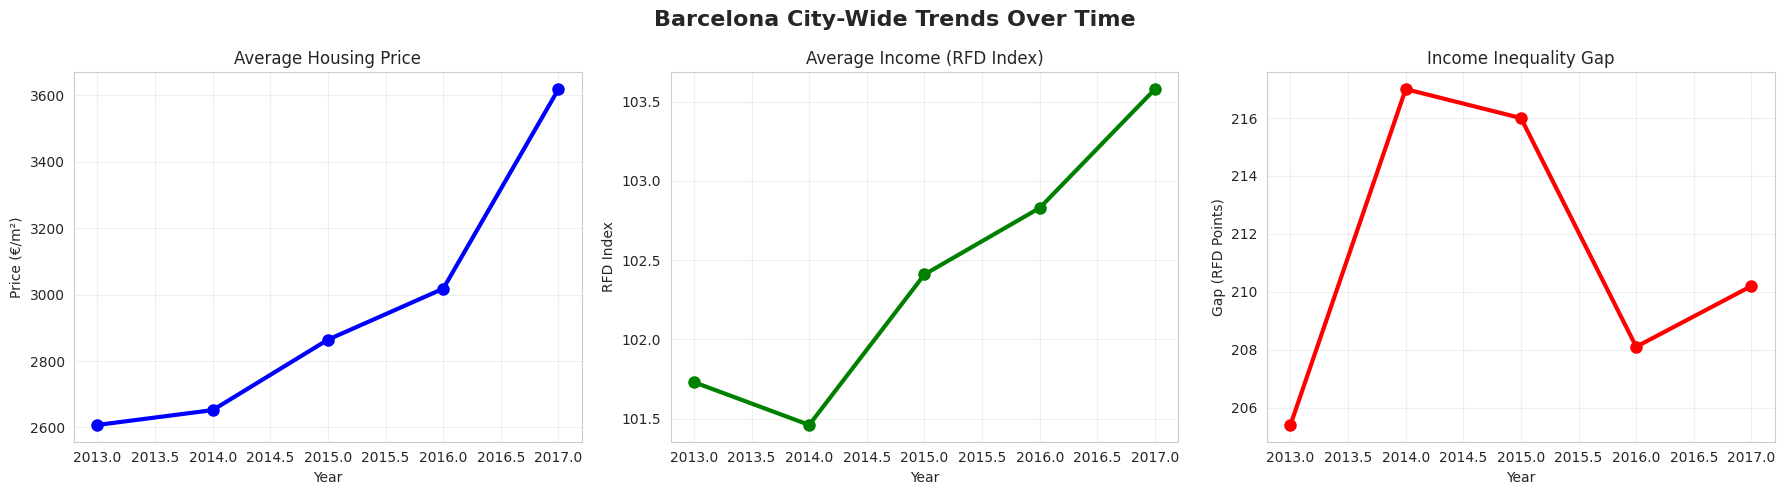

In [22]:
# ========================================
# 1. CITY-WIDE TRENDS (LINE CHARTS)
# ========================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Barcelona City-Wide Trends Over Time', fontsize=16, fontweight='bold')

# 1.1 Average Price Evolution
yearly_prices = district_df.groupby('year')['kpi_2_avg_price_per_m2'].mean()
ax1.plot(yearly_prices.index, yearly_prices.values, marker='o', linewidth=3, markersize=8, color='blue')
ax1.set_title('Average Housing Price')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price (€/m²)')
ax1.grid(True, alpha=0.3)

# 1.2 Average Income Evolution
yearly_income = district_df.groupby('year')['kpi_3_avg_rfd_index'].mean()
ax2.plot(yearly_income.index, yearly_income.values, marker='o', linewidth=3, markersize=8, color='green')
ax2.set_title('Average Income (RFD Index)')
ax2.set_xlabel('Year')
ax2.set_ylabel('RFD Index')
ax2.grid(True, alpha=0.3)

# 1.3 Income Inequality
ax3.plot(city_df['year'], city_df['kpi_4_inequality_gap'], marker='o', linewidth=3, markersize=8, color='red')
ax3.set_title('Income Inequality Gap')
ax3.set_xlabel('Year')
ax3.set_ylabel('Gap (RFD Points)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We begin our dashboard with simple line plots showing the evolution of
1. Price vs. Income growth normalized in Barcelona
2. The average income (by RFD index) in Barcelona
3. The income equality gap calculated as the difference between min and max incomes

We can see that average housing price is incresaing from 2013 to 2017, and also the RFD Index is increasing impyting that incomes are also increasing. The biggeest change in housing prices is from 2016 to 2017, and we don't see an equivalent jump in incomes, hence implying that relatively in 2017 housing prices probably got significantly more expensive.

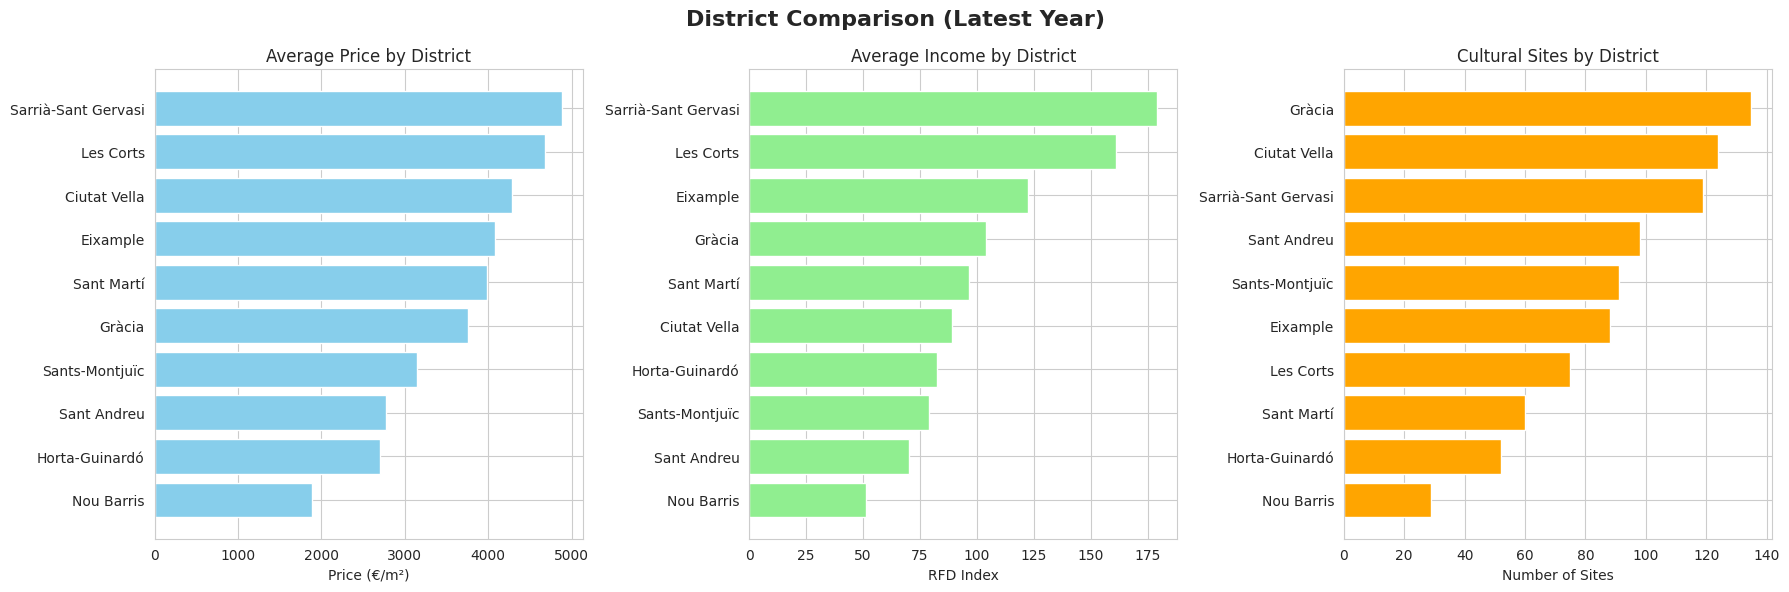

In [23]:
# ========================================
# 2. DISTRICT COMPARISON (BAR CHARTS)
# ========================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('District Comparison (Latest Year)', fontsize=16, fontweight='bold')

latest_year = district_df['year'].max()
latest_data = district_df[district_df['year'] == latest_year].sort_values('kpi_2_avg_price_per_m2')

# 2.1 Prices by District
ax1.barh(latest_data['district_name'], latest_data['kpi_2_avg_price_per_m2'], color='skyblue')
ax1.set_title('Average Price by District')
ax1.set_xlabel('Price (€/m²)')

# 2.2 Income by District
income_sorted = latest_data.sort_values('kpi_3_avg_rfd_index')
ax2.barh(income_sorted['district_name'], income_sorted['kpi_3_avg_rfd_index'], color='lightgreen')
ax2.set_title('Average Income by District')
ax2.set_xlabel('RFD Index')

# 2.3 Cultural Sites by District
culture_sorted = latest_data.sort_values('kpi_1_cultural_sites_count')
ax3.barh(culture_sorted['district_name'], culture_sorted['kpi_1_cultural_sites_count'], color='orange')
ax3.set_title('Cultural Sites by District')
ax3.set_xlabel('Number of Sites')

plt.tight_layout()
plt.show()

Next, we look at a breakdown by districts. We can see that the average house price and average incomes are often correlated. This makes sense and suggests that high-income earners generally seek high-income districts for living, and also implies that high-income earners can afford more. We also see that Higher price and income areas generally have more cultural sites available, implying that the number of cultural sites may have an influence on the housing prices, though this is purely a hypothesis.

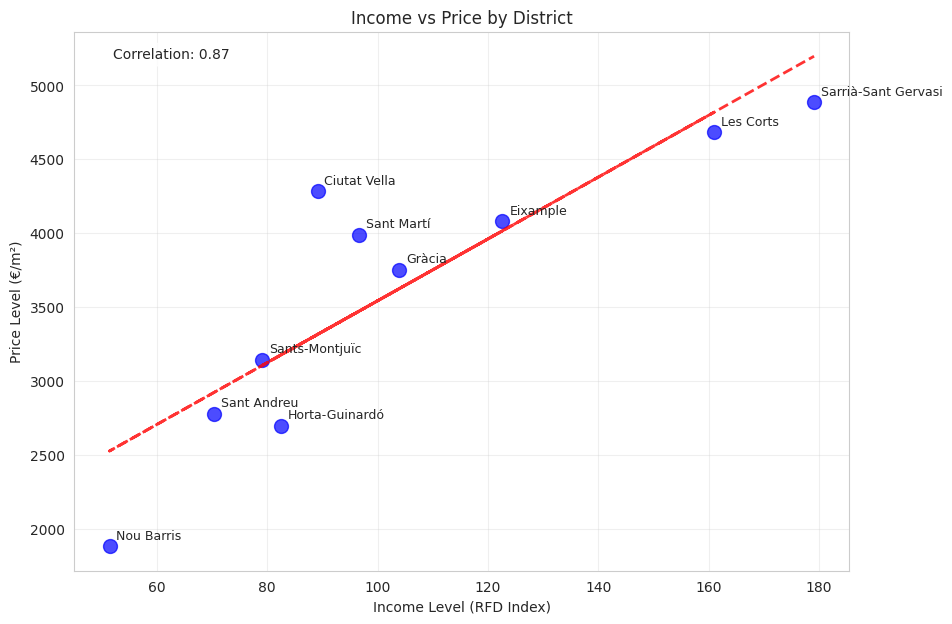

In [24]:

# Get latest year data
district_df = district_kpis.toPandas()
latest_year = district_df['year'].max()
latest_data = district_df[district_df['year'] == latest_year]

plt.figure(figsize=(10, 7))

# Simple scatter plot
plt.scatter(latest_data['kpi_3_avg_rfd_index'],
           latest_data['kpi_2_avg_price_per_m2'],
           s=100, alpha=0.7, color='blue')

# Add district labels
for idx, row in latest_data.iterrows():
    plt.annotate(row['district_name'],
                (row['kpi_3_avg_rfd_index'], row['kpi_2_avg_price_per_m2']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add trend line
import numpy as np
z = np.polyfit(latest_data['kpi_3_avg_rfd_index'], latest_data['kpi_2_avg_price_per_m2'], 1)
p = np.poly1d(z)
plt.plot(latest_data['kpi_3_avg_rfd_index'],
         p(latest_data['kpi_3_avg_rfd_index']),
         "r--", alpha=0.8, linewidth=2)

# Show correlation
corr = latest_data['kpi_3_avg_rfd_index'].corr(latest_data['kpi_2_avg_price_per_m2'])
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.xlabel('Income Level (RFD Index)')
plt.ylabel('Price Level (€/m²)')
plt.title('Income vs Price by District')
plt.grid(True, alpha=0.3)
plt.show()

Taking, a closer look at the relationship between income level and price level, we see that there is a correlation of 0.87 aligning with our previous findings.

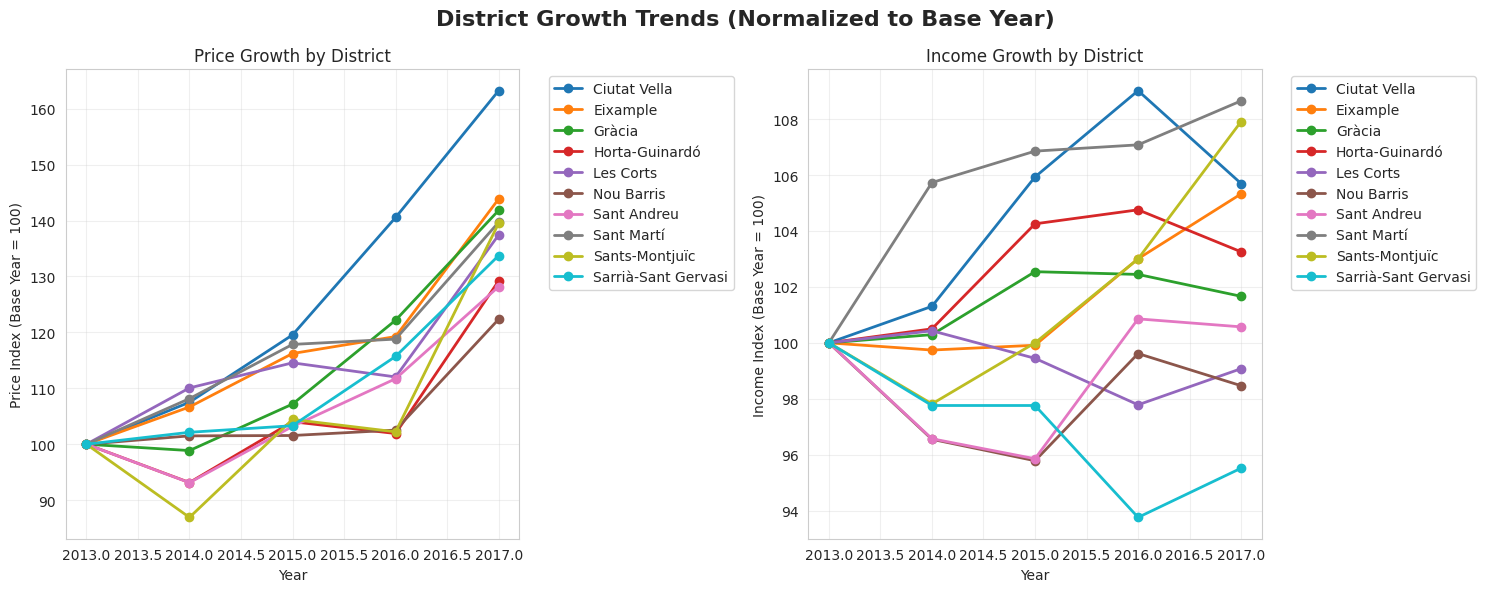

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('District Growth Trends (Normalized to Base Year)', fontsize=16, fontweight='bold')

districts = district_df['district_name'].unique()

# 1.1 Normalized Price Growth
for district in districts:
    district_data = district_df[district_df['district_name'] == district].sort_values('year')
    if len(district_data) > 1:
        # Normalize to base year = 100
        normalized_prices = (district_data['kpi_2_avg_price_per_m2'] / district_data['kpi_2_avg_price_per_m2'].iloc[0]) * 100
        ax1.plot(district_data['year'], normalized_prices,
                marker='o', label=district, linewidth=2)

ax1.set_title('Price Growth by District')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price Index (Base Year = 100)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 1.2 Normalized Income Growth
for district in districts:
    district_data = district_df[district_df['district_name'] == district].sort_values('year')
    if len(district_data) > 1:
        # Normalize to base year = 100
        normalized_income = (district_data['kpi_3_avg_rfd_index'] / district_data['kpi_3_avg_rfd_index'].iloc[0]) * 100
        ax2.plot(district_data['year'], normalized_income,
                marker='o', label=district, linewidth=2)

ax2.set_title('Income Growth by District')
ax2.set_xlabel('Year')
ax2.set_ylabel('Income Index (Base Year = 100)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

If we look at the district growth using an index, we can see that the most substantial increase in house prices is in Ciutat Vella. Most other distrcits like between 120-140 relative to the base year (2013), i.e. still a substanital increase, but clearly Ciutat Vella dominates among these districts.

Regarding, incomes we see that there is no such clear pattern. Some districts see increasing income pattern, while others see decreasing. This points to increasing upwards pressure on housing prices, with somewhat stagnating incomes, making overall life more expensive.

In [26]:
# ========================================
# 5.SUMMARY TABLE
# ========================================

print("\nDISTRICT RANKINGS (Latest Year)")
print("=" * 50)

# Create summary rankings
summary = latest_data[['district_name', 'kpi_2_avg_price_per_m2', 'kpi_3_avg_rfd_index',
                      'kpi_1_cultural_sites_count']].round(0)
summary.columns = ['District', 'Price (€/m²)', 'Income (RFD)', 'Cultural Sites']
summary = summary.sort_values('Price (€/m²)', ascending=False)

print(summary.to_string(index=False))


DISTRICT RANKINGS (Latest Year)
           District  Price (€/m²)  Income (RFD)  Cultural Sites
Sarrià-Sant Gervasi        4888.0         179.0             119
          Les Corts        4682.0         161.0              75
       Ciutat Vella        4283.0          89.0             124
           Eixample        4080.0         123.0              88
         Sant Martí        3991.0          97.0              60
             Gràcia        3754.0         104.0             135
     Sants-Montjuïc        3146.0          79.0              91
        Sant Andreu        2779.0          70.0              98
     Horta-Guinardó        2698.0          82.0              52
         Nou Barris        1883.0          51.0              29


Finally, we present an overall summary table of the price, income (RFD index) and cultural sites in the districts of Barcelona.

Based on the district rankings, Barcelona shows a clear pattern of spatial inequality. Sarrià-Sant Gervasi dominates as the city's most exclusive district with the highest prices (€4,888/m²) and income levels (RFD 179), while Nou Barris represents the opposite extreme with the lowest prices (€1,883/m²) and income (RFD 51) - creating a striking 2.6x price gap across the city. Interestingly, cultural resources don't always align with wealth: Gràcia leads in cultural sites (135) despite moderate income levels, while wealthy Les Corts has relatively fewer cultural amenities (75). The data reveals a concerning pattern where Ciutat Vella, despite having the second-highest cultural offerings (124 sites), shows low income levels (RFD 89) but high prices (€4,283/m²) - suggesting potential gentrification pressure pushing out long-term residents. This spatial divide highlights Barcelona's challenge of balancing urban development with social equity across its diverse districts.

In [27]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Convert Spark DataFrames to Pandas
district_df = district_kpis.toPandas()
city_df = city_kpis.toPandas()

# Latest year filter
latest_year = district_df['year'].max()
latest_data = district_df[district_df['year'] == latest_year]

# ========== 1. CITY-WIDE TRENDS (LINE CHARTS) ==========
fig_city = make_subplots(rows=1, cols=3, subplot_titles=(
    'Average Housing Price',
    'Average Income (RFD Index)',
    'Income Inequality Gap'))

# 1.1 Average Price Evolution
yearly_prices = district_df.groupby('year')['kpi_2_avg_price_per_m2'].mean()
fig_city.add_trace(go.Scatter(x=yearly_prices.index, y=yearly_prices.values, mode='lines+markers',
                              name='Avg Price €/m²', line=dict(color='blue')), row=1, col=1)

# 1.2 Average Income Evolution
yearly_income = district_df.groupby('year')['kpi_3_avg_rfd_index'].mean()
fig_city.add_trace(go.Scatter(x=yearly_income.index, y=yearly_income.values, mode='lines+markers',
                              name='Avg Income RFD', line=dict(color='green')), row=1, col=2)

# 1.3 Income Inequality Gap
fig_city.add_trace(go.Scatter(x=city_df['year'], y=city_df['kpi_4_inequality_gap'], mode='lines+markers',
                              name='Inequality Gap', line=dict(color='red')), row=1, col=3)

fig_city.update_layout(title_text="Barcelona City-Wide Trends Over Time", height=400, width=1000)
fig_city.update_xaxes(title_text='Year', row=1, col=1)
fig_city.update_yaxes(title_text='Price (€/m²)', row=1, col=1)
fig_city.update_xaxes(title_text='Year', row=1, col=2)
fig_city.update_yaxes(title_text='RFD Index', row=1, col=2)
fig_city.update_xaxes(title_text='Year', row=1, col=3)
fig_city.update_yaxes(title_text='Gap (RFD Points)', row=1, col=3)
fig_city.show()

# ========== 2. DISTRICT COMPARISON (BAR CHARTS) ==========
fig_district = make_subplots(rows=1, cols=3, subplot_titles=(
    'Average Price by District',
    'Average Income by District',
    'Cultural Sites by District'))

# Sort data for better visuals
latest_data_sorted_price = latest_data.sort_values('kpi_2_avg_price_per_m2')
latest_data_sorted_income = latest_data.sort_values('kpi_3_avg_rfd_index')
latest_data_sorted_culture = latest_data.sort_values('kpi_1_cultural_sites_count')

fig_district.add_trace(go.Bar(x=latest_data_sorted_price['kpi_2_avg_price_per_m2'], y=latest_data_sorted_price['district_name'],
                              orientation='h', marker_color='skyblue', name='Price €/m²'), row=1, col=1)
fig_district.add_trace(go.Bar(x=latest_data_sorted_income['kpi_3_avg_rfd_index'], y=latest_data_sorted_income['district_name'],
                              orientation='h', marker_color='lightgreen', name='Income RFD'), row=1, col=2)
fig_district.add_trace(go.Bar(x=latest_data_sorted_culture['kpi_1_cultural_sites_count'], y=latest_data_sorted_culture['district_name'],
                              orientation='h', marker_color='orange', name='Cultural Sites'), row=1, col=3)

fig_district.update_layout(title_text=f'District Comparison (Latest Year: {latest_year})', height=500, width=1000)
fig_district.update_xaxes(title_text='Price (€/m²)', row=1, col=1)
fig_district.update_xaxes(title_text='RFD Index', row=1, col=2)
fig_district.update_xaxes(title_text='Number of Sites', row=1, col=3)
fig_district.show()

# ========== 3. INCOME VS PRICE SCATTER ==========
corr = latest_data['kpi_3_avg_rfd_index'].corr(latest_data['kpi_2_avg_price_per_m2'])

fig_scatter = px.scatter(latest_data,
                         x='kpi_3_avg_rfd_index',
                         y='kpi_2_avg_price_per_m2',
                         text='district_name',
                         labels={
                             'kpi_3_avg_rfd_index': 'Income Level (RFD Index)',
                             'kpi_2_avg_price_per_m2': 'Price Level (€/m²)'
                         },
                         title=f'Income vs Price by District (Correlation: {corr:.2f})',
                         trendline="ols",
                         width=800, height=600)
fig_scatter.update_traces(textposition='top center')
fig_scatter.show()

# ========== 4. DISTRICT GROWTH TRENDS (NORMALIZED) ==========
fig_growth = make_subplots(rows=1, cols=2, subplot_titles=(
    'Price Growth by District (Index)',
    'Income Growth by District (Index)'))

districts = district_df['district_name'].unique()

for district in districts:
    district_data = district_df[district_df['district_name'] == district].sort_values('year')
    if len(district_data) > 1:
        norm_price = (district_data['kpi_2_avg_price_per_m2'] / district_data['kpi_2_avg_price_per_m2'].iloc[0]) * 100
        norm_income = (district_data['kpi_3_avg_rfd_index'] / district_data['kpi_3_avg_rfd_index'].iloc[0]) * 100
        fig_growth.add_trace(go.Scatter(x=district_data['year'], y=norm_price, mode='lines+markers', name=district), row=1, col=1)
        fig_growth.add_trace(go.Scatter(x=district_data['year'], y=norm_income, mode='lines+markers', name=district, showlegend=False), row=1, col=2)

fig_growth.update_layout(title_text='District Growth Trends (Normalized to Base Year)', height=400, width=1000)
fig_growth.update_xaxes(title_text='Year', row=1, col=1)
fig_growth.update_yaxes(title_text='Price Index (Base Year=100)', row=1, col=1)
fig_growth.update_xaxes(title_text='Year', row=1, col=2)
fig_growth.update_yaxes(title_text='Income Index (Base Year=100)', row=1, col=2)
fig_growth.show()

# ========== 5. SUMMARY TABLE ==========
summary = latest_data[['district_name', 'kpi_2_avg_price_per_m2', 'kpi_3_avg_rfd_index', 'kpi_1_cultural_sites_count']].round(0)
summary.columns = ['District', 'Price (€/m²)', 'Income (RFD)', 'Cultural Sites']
summary = summary.sort_values('Price (€/m²)', ascending=False)

import plotly.figure_factory as ff

table_fig = ff.create_table(summary)
table_fig.update_layout(width=700, height=600, title="District Rankings (Latest Year)")
table_fig.show()


In [28]:
## END OF NOTEBOOK